In [44]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ipyleaflet import Map

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', True)
plt.style.use("seaborn-v0_8-bright")

In [436]:
# !~/homebrew/anaconda3/envs/dota/bin/pip install geopandas

In [27]:
TASK_DATA_DIR = Path("../task_data/")
DATA_DIR = Path('../data/')

In [34]:
address_data = pd.read_csv(DATA_DIR / 'data-60562-2024-05-24.csv', sep=';', low_memory=False)
column_description = address_data.iloc[0]
address_data = address_data.iloc[1:].reset_index(drop=True)

filtered_data = address_data[
    (address_data.geodata_center.notna()) &
    (address_data.UNOM.notna())
]

display(filtered_data.shape)

filtered_data_target_cols = filtered_data[['global_id', 'UNOM', 'DISTRICT', 'SIMPLE_ADDRESS', 'ADM_AREA', 'geodata_center']].copy()
filtered_data_target_cols.geodata_center = filtered_data_target_cols.geodata_center.apply(lambda x: x.split('=')[1].split(', type')[0])
filtered_data_target_cols.reset_index(drop=True, inplace=True)

(480391, 45)

In [45]:
UNOM_to_address_info = {}
for row in tqdm(filtered_data.itertuples(), total=filtered_data.shape[0]):
    UNOM_to_address_info[row.UNOM] = row.geodata_center

  0%|          | 0/480391 [00:00<?, ?it/s]

In [3]:
COLUMNS_RENAME_DICT = {
    'Наименование': 'event_name',
    'Источник': 'source',
    'Дата создания во внешней системе': 'start_timestamp',
    'Дата закрытия': 'fact_end_timestamp',
    'Округ': 'adm_area',
    'УНОМ': 'UNOM',
    'Адрес': 'address',
    'Дата и время завершения события во внешней системе': 'end_timestamp',
    'Дата и время завершения события': 'end_timestamp'
}
DATE_COLS = ['start_timestamp', 'fact_end_timestamp', 'end_timestamp']

def load_and_prepare_events_df(path, sheet_name=1):
    events_df = pd.read_excel(path, sheet_name=sheet_name )
    events_df = events_df.rename(columns=COLUMNS_RENAME_DICT)
    
    events_df = events_df[events_df.UNOM.notna()]
    events_df['UNOM'] = events_df['UNOM'].astype(np.int64)
    events_df[DATE_COLS] = events_df[DATE_COLS].fillna("1970-01-01 00:00:00.000000").astype("datetime64[ns]")
    return events_df

In [5]:
events_df_1 = load_and_prepare_events_df(TASK_DATA_DIR / 'events' / 'events_01.10.2023-31.12.2023.xlsx')
events_df_2 = load_and_prepare_events_df(TASK_DATA_DIR / 'events' / 'events_01.01.2024-30.04.2024.xlsx')

In [6]:
events_df_1 = events_df_1[(events_df_1.start_timestamp >= '2023-10-01') 
                        & (events_df_1.start_timestamp <  '2024-01-01')]
events_df_2 = events_df_2[(events_df_2.start_timestamp >= '2024-01-01') 
                        & (events_df_2.start_timestamp <  '2024-05-01')]
events_df = pd.concat((events_df_1, events_df_2)).reset_index(drop=True)

In [7]:
# TARGET_EVENTS = set([
#     "Температура в квартире ниже нормативной", "Температура ГВС ниже нормы", "Отсутствие ГВС в доме", 
#     "Недогрев ГВС", "Отсутствует циркуляция ГВС", "Отсутствие ХВС в доме", "Протечка с кровли", 
#     "Аварийная протечка с кровли", "T1 > max", "Отклонение ГВС ниже нормы днем (мониторинг)", 
#     "Протечка в подъезде", "Отсутствие отопления в доме", "Аварийная протечка в подъезде", 
#     "Критичное отклонение температуры ГВС ниже нормы днем (мониторинг)", "P1 <= 0", "T1 < min", 
#     "Критичное отклонение температуры ГВС ниже нормы ночью (мониторинг)", 
#     "Отклонение ГВС ниже нормы ночью (мониторинг)", "Температура в помещении общего пользования ниже нормативной", 
#     "Сильная течь в системе отопления", "Течь в системе отопления", "Протечка с балкона/козырька", 
#     "Аварийный прорыв трубы", "P2 <= 0", "Аномальное значение разницы температур", "Протечка труб в подъезде", 
#     "Аномальное значение температуры в подающем трубопроводе", "Аномальное значение объема в обратном трубопроводе", 
#     "Прорыв трубы", "Аномальное значение температуры в обратном трубопроводе", 
#     "Аномальное значение объема в подающем трубопроводе", "Аномальное значение массы в подающем трубопроводе", 
#     "Аномальное значение отпущенной тепловой энергии", "Аварийная протечка труб в подъезде", "Пожар", "Крупные пожары"
# ])

TARGET_EVENTS = set([
    'P1 <= 0', 'P2 <= 0', 'T1 < min', 'T1 > max',
    'Аварийная протечка труб в подъезде', 'Крупные пожары',
    'Отсутствие отопления в доме', 'Протечка труб в подъезде',
    'Сильная течь в системе отопления',
    'Течь в системе отопления'
])

OTHER_TARGET_EVENTS = set([
    'Температура в помещении общего пользования ниже нормативной',
    'Температура в квартире ниже нормативной',
])

target_events_df = events_df[events_df.event_name.isin(TARGET_EVENTS)].reset_index(drop=True)
target_events_df['start_date'] = target_events_df.start_timestamp.dt.date.astype("datetime64[ns]")
target_events_df = target_events_df[
    ~((target_events_df.fact_end_timestamp == '1970-01-01')
    & (target_events_df.end_timestamp == '1970-01-01'))
]

display(target_events_df.shape)
target_events_df.event_name.value_counts()

(12392, 9)

event_name
T1 > max                              5297
Отсутствие отопления в доме           2387
P1 <= 0                               1372
T1 < min                              1324
Сильная течь в системе отопления      676 
Течь в системе отопления              567 
P2 <= 0                               465 
Протечка труб в подъезде              300 
Аварийная протечка труб в подъезде    3   
Крупные пожары                        1   
Name: count, dtype: int64

In [8]:
def plot_date_values(dates, values):
    plt.fill_between(dates, values, alpha=0.5)
    plt.plot(dates, values, drawstyle="steps")

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.gcf().autofmt_xdate()
    plt.xlim(dates[0], dates[-1])
    plt.ylim(values.min() * 0.8)
    plt.gcf().set_dpi(150)

    plt.show()

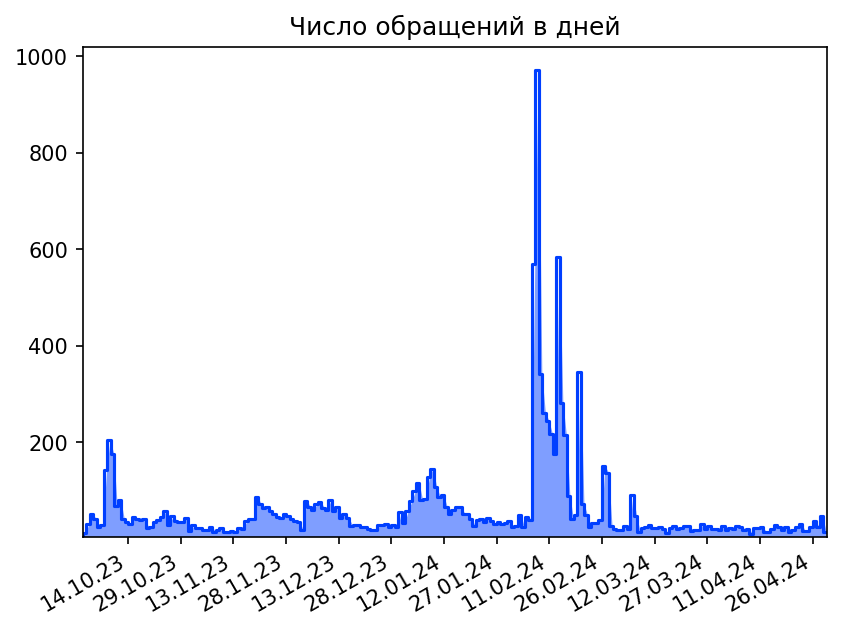

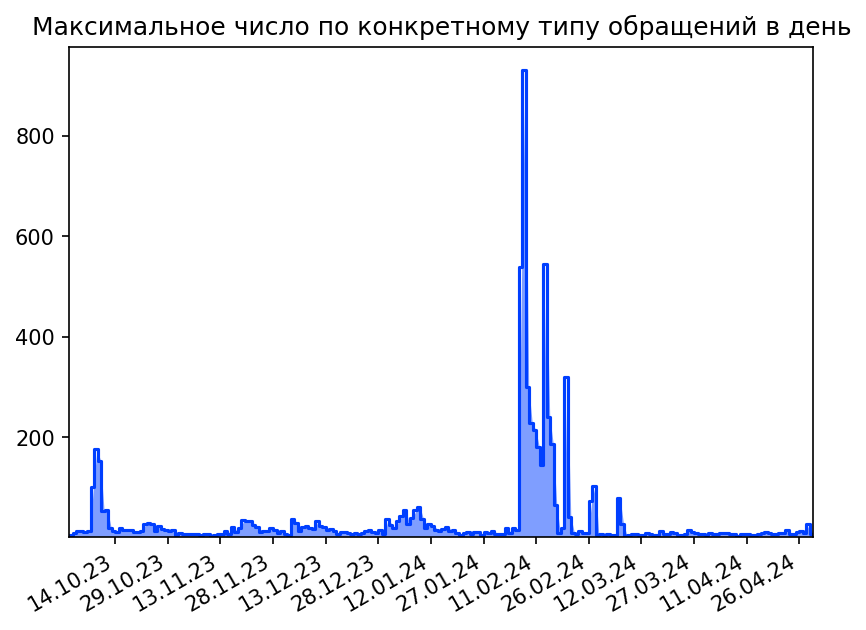

In [9]:
dt_to_event_count = target_events_df.start_timestamp.dt.date.value_counts().sort_index().reset_index()
dt_to_event_count.start_timestamp = dt_to_event_count.start_timestamp.astype("datetime64[ns]")
plt.title('Число обращений в дней')
plot_date_values(dt_to_event_count.start_timestamp.values, dt_to_event_count['count'])

plt.title('Максимальное число по конкретному типу обращений в день')
date_to_max_events = target_events_df[['start_date', 'event_name', 'UNOM']].groupby(['start_date', 'event_name']).count().groupby('start_date').max()
plot_date_values(date_to_max_events.index, date_to_max_events.UNOM)

In [12]:
target_events_df[target_events_df.start_date > '2024-01-27'].start_date.value_counts()

start_date
2024-02-08    971
2024-02-14    584
2024-02-07    570
2024-02-20    346
2024-02-09    342
             ... 
2024-04-14    14 
2024-03-08    14 
2024-04-13    13 
2024-03-16    12 
2024-04-09    10 
Name: count, Length: 94, dtype: int64

In [48]:
target_events_df[target_events_df.start_date == '2024-02-08'].event_name.value_counts()

event_name
T1 > max                            930
T1 < min                            9  
Отсутствие отопления в доме         9  
P2 <= 0                             8  
Течь в системе отопления            7  
P1 <= 0                             5  
Сильная течь в системе отопления    3  
Name: count, dtype: int64

In [50]:
df = target_events_df[(target_events_df.start_date == '2024-02-08') & (target_events_df.event_name == 'T1 > max')].head()

In [55]:
# m = Map(center=[55.787715, 37.775631], zoom=12)

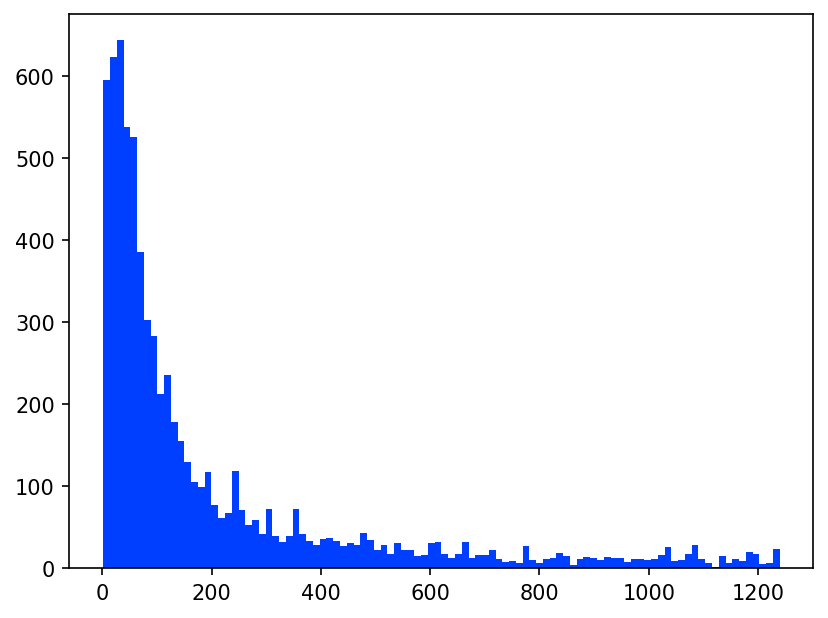

In [61]:
df = target_events_df[target_events_df.end_timestamp > target_events_df.start_timestamp]
df = (df.end_timestamp - df.start_timestamp).dt.total_seconds() / 60
plt.hist(df[df < df.quantile(0.7)], bins=100)
plt.gcf().set_dpi(150)
plt.show()

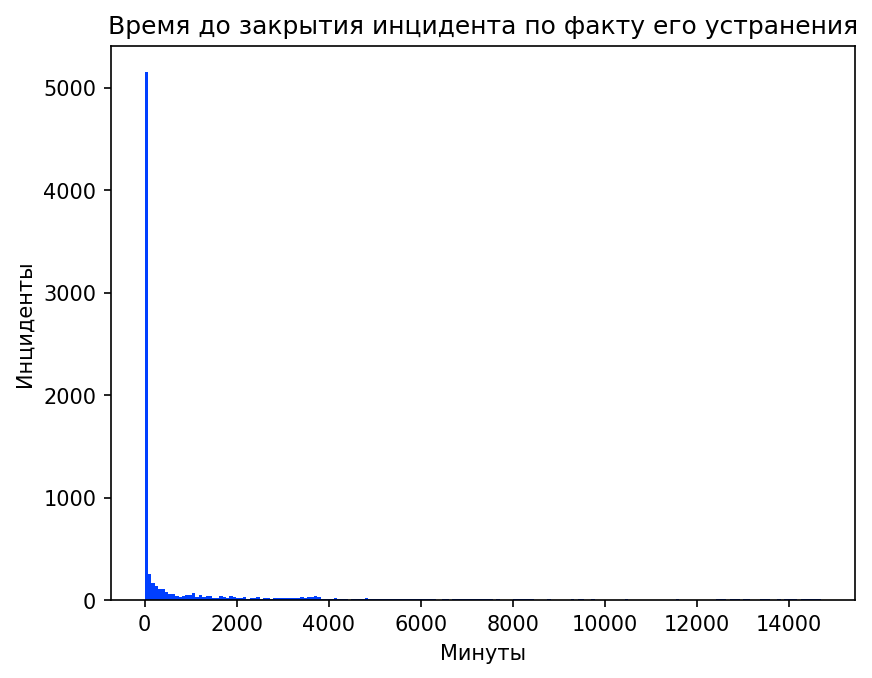

In [63]:
df = target_events_df[target_events_df.fact_end_timestamp > target_events_df.start_timestamp]
df = (df.fact_end_timestamp - df.start_timestamp).dt.total_seconds() / 60
plt.hist(df[df < df.quantile(0.7)], bins=200)
plt.title('Время до закрытия инцидента по факту его устранения')
plt.xlabel('Минуты')
plt.ylabel('Инциденты')
plt.gcf().set_dpi(150)
plt.show()

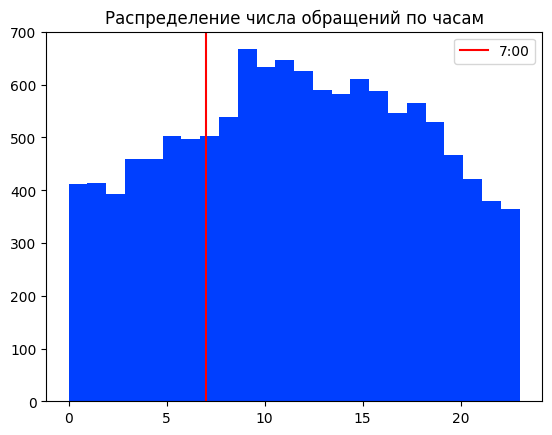

In [56]:
plt.hist(target_events_df.start_timestamp.dt.hour, bins=24)
plt.axvline(7, 0, 1, color='red', label='7:00')
plt.title('Распределение числа обращений по часам')
plt.legend()
plt.show()

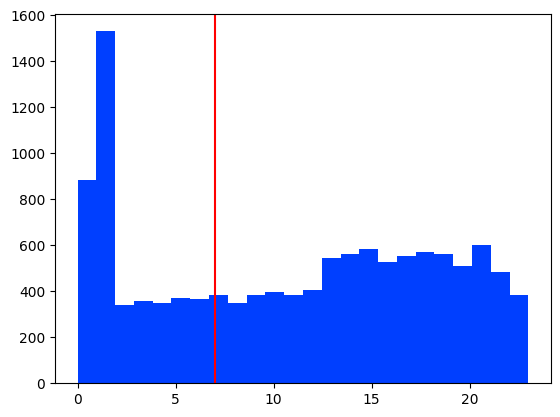

In [57]:
plt.hist(target_events_df.fact_end_timestamp.dt.hour, bins=24)
plt.axvline(7, 0, 1, color='red')
plt.show()

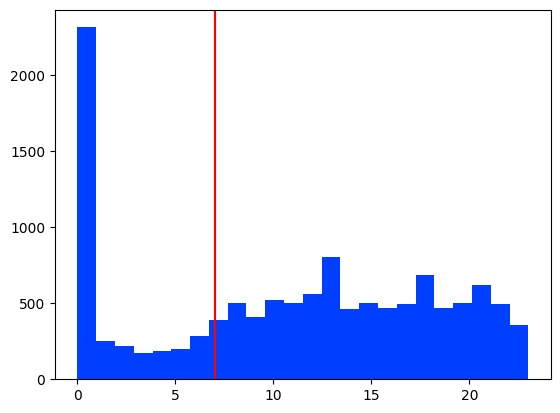

In [58]:
plt.hist(target_events_df.end_timestamp.dt.hour, bins=24)
plt.axvline(7, 0, 1, color='red')
plt.show()